<a href="https://colab.research.google.com/github/TPincher/IntroToPyTorch/blob/main/ConvolutionalNeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
# Convert MNIST Image Files into a Tensor of 4-dimensions (# of images, height, width, colour channels)
transform = transforms.ToTensor()

In [26]:
# Train Data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

In [27]:
# Test Data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [28]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [29]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [30]:
# Create a small batch size for images. Usually 2 to 4, but will use 10 for this.
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [31]:
# Define our CNN Model
# Describe convolutional layer and what it's doing (2 convolutional layers)
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [32]:
# Grab 1 MNIST image/record
for i, (X_train, y_train) in enumerate(train_data):
  break

In [33]:
x = X_train.view(1, 1, 28, 28)

In [34]:
# Perform our first convolution
  #Rectified Linear Unit for our activation function
x = F.relu(conv1(x))

In [35]:
# 1 single image, 6 is the filters we asked for, 26x26 is now the size of the image. It's come down from 28x28 as the outer edge of pixels is dropped unless padding is handled
x.shape

torch.Size([1, 6, 26, 26])

In [36]:
# pass through the pooling layer
  # Kernel of 2 and stride of 2
x = F.max_pool2d(x, 2, 2)

In [37]:
# we get 13x13 here as each block of 2x2 has been shrunk down into a single point
x.shape

torch.Size([1, 6, 13, 13])

In [38]:
# Do our second convolutional layer
x = F.relu(conv2(x))

In [39]:
# Again, no padding so outermost layer of pixels is lost
x.shape

torch.Size([1, 16, 11, 11])

In [40]:
# Pooling layer
x = F.max_pool2d(x, 2, 2)

In [41]:
# 11 rounds down to 5 because data can't be invented to round up.
x.shape

torch.Size([1, 16, 5, 5])

In [42]:
# Model Class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)
    # Fully connected layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    # 2x2 kernel and a stride of 2
    X = F.max_pool2d(X, 2, 2)
    X = F.relu(self.conv2(X))
    # 2x2 kernel and a stride of 2
    X = F.max_pool2d(X, 2, 2)

    # Re-View to flatten it out
    X = X.view(-1, 16*5*5)

    # Fully connected layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)

In [43]:
# Create an instance of the Model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [44]:
# Loss function optimizer
criterion = nn.CrossEntropyLoss()
# The smaller the learning rate, the long it will take to train
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [47]:
import time
start_time = time.time()

# Create variables to track things so we can break this apart after the fact
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For loop for epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  # Train
  for b,(X_train, y_train) in enumerate(train_loader):
    # Start batches at 1
    b+=1
    # Get predicted values from the training set. These are 2d, not flattened.
    y_pred = model(X_train)
    # Compare predictions to correct answers in y_train to see how off we are.
    loss = criterion(y_pred, y_train)
    # Add up the number of correct predictions, indexed off the first point.
    predicted = torch.max(y_pred.data, 1)[1]
    # How many we got correct from this specific batch. True = 1, False = 0.
    batch_corr = (predicted == y_train).sum()
    # Keep track as we go along in training
    trn_corr += batch_corr

    # Update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print out results
    if b%600 == 0:
      print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  # Test
  # No gradient so we don't update our weights and biases with test data
  with torch.no_grad():
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      # Addinmg up correct predictions
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)


current_time = time.time()
total = current_time - start_time
print(f'Training took: {total/60} minutes')

Epoch: 0 Batch: 600 Loss: 0.009655272588133812
Epoch: 0 Batch: 1200 Loss: 0.0012097712606191635
Epoch: 0 Batch: 1800 Loss: 0.10811348259449005
Epoch: 0 Batch: 2400 Loss: 0.01688917726278305
Epoch: 0 Batch: 3000 Loss: 0.025794899091124535
Epoch: 0 Batch: 3600 Loss: 0.00010044014925369993
Epoch: 0 Batch: 4200 Loss: 5.256626900518313e-05
Epoch: 0 Batch: 4800 Loss: 0.0002409588050795719
Epoch: 0 Batch: 5400 Loss: 0.007484280504286289
Epoch: 0 Batch: 6000 Loss: 0.0020166474860161543
Epoch: 1 Batch: 600 Loss: 0.04252638295292854
Epoch: 1 Batch: 1200 Loss: 0.004576195031404495
Epoch: 1 Batch: 1800 Loss: 5.895288268220611e-05
Epoch: 1 Batch: 2400 Loss: 0.00983492098748684
Epoch: 1 Batch: 3000 Loss: 0.4969000220298767
Epoch: 1 Batch: 3600 Loss: 0.0004898829502053559
Epoch: 1 Batch: 4200 Loss: 0.0032431185245513916
Epoch: 1 Batch: 4800 Loss: 0.0092580895870924
Epoch: 1 Batch: 5400 Loss: 0.0016663905698806047
Epoch: 1 Batch: 6000 Loss: 0.0007101414375938475
Epoch: 2 Batch: 600 Loss: 0.00041558610

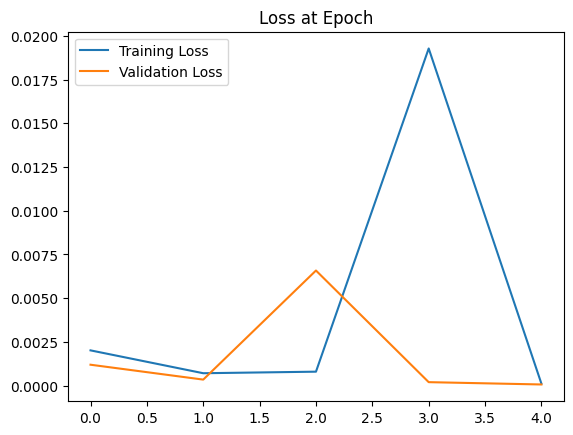

In [50]:
# Graph the loss at epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()

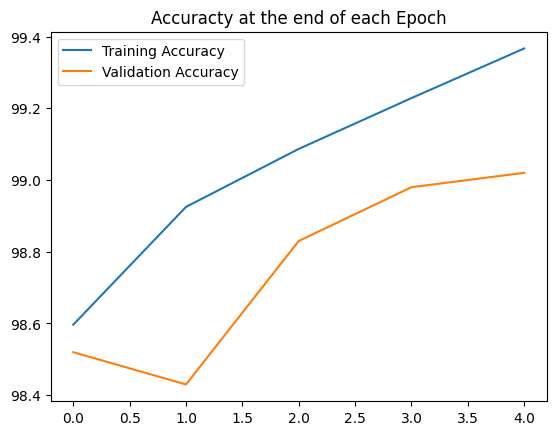

In [55]:
# Graph accuracy at the end of each Epoch
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracty at the end of each Epoch")
plt.legend()

In [56]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [59]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [62]:
correct.item()/len(test_data)

0.9902

In [63]:
# Grab an image
# This is a tensor with an image in it from the test data set. At the end of the tensor it shows the label.
test_data[4143]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [64]:
# Grab just the data out of it
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [65]:
# Reshape it
test_data[4143][0].reshape(28, 28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

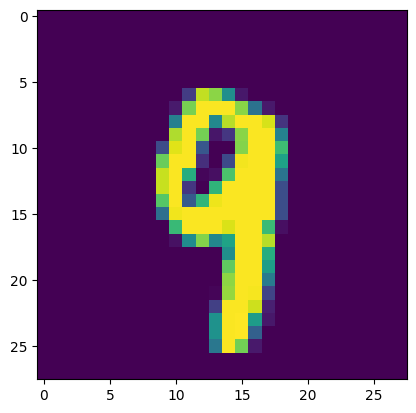

In [67]:
# Show the image
plt.imshow(test_data[4143][0].reshape(28, 28))

In [68]:
# Pass the image through the model
model.eval()
with torch.no_grad():
  # Batch size of 1, 1 colour channel, 28x28 image size
  new_prediction = model(test_data[4143][0].view(1, 1, 28, 28))

In [69]:
# Check the new prediction, which will get probabilities
new_prediction

tensor([[-32.5748, -27.7217, -34.9624, -25.6595, -16.6525, -23.7877, -46.1920,
         -19.6674, -22.0347,   0.0000]])

In [70]:
new_prediction.argmax()

tensor(9)